In [ ]:
# =====================================================
# STEP 1: INSTALL & IMPORT LIBRARIES
# =====================================================
!pip install -q kagglehub tensorflow scikit-learn pandas numpy matplotlib seaborn


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, precision_recall_curve, auc, confusion_matrix
)
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten,
LSTM, Bidirectional, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [ ]:
# =====================================================
# STEP 2: DOWNLOAD DATASET USING KAGGLE HUB
# =====================================================
import kagglehub


dataset_path = kagglehub.dataset_download(
"agungpambudi/network-malware-detection-connection-analysis"
)
print("Dataset path:", dataset_path)


Using Colab cache for faster access to the 'network-malware-detection-connection-analysis' dataset.
Dataset path: /kaggle/input/network-malware-detection-connection-analysis


In [ ]:
# =====================================================
# STEP 3: LOAD CSV DATA
# =====================================================
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
print("CSV files:", csv_files)


data = pd.read_csv(os.path.join(dataset_path, csv_files[0]))
print(data.head())
print(data.columns)

CSV files: ['CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-44-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv', 'CTU-IoT-Malware-Capture-9-1conn.log.labeled.csv']
  ts|uid|id.orig_h|id.orig_p|id.resp_h|id.resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|label|detailed-label
0  1533042911.474174|C5JLGOoxIw2dBZt47|192.168.10...                                                                                    

In [ ]:
print(data.columns)


Index(['ts|uid|id.orig_h|id.orig_p|id.resp_h|id.resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|label|detailed-label'], dtype='object')


In [ ]:
# =====================================================
# STEP 4: ROBUST PREPROCESSING (ZEEK FLOW DATA)
# =====================================================

import numpy as np

# 1️⃣ Handle pipe-separated single-column CSV
if len(data.columns) == 1 and '|' in data.columns[0]:
    data = data[data.columns[0]].str.split('|', expand=True)
    data.columns = [
        'ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p',
        'proto','service','duration','orig_bytes','resp_bytes',
        'conn_state','local_orig','local_resp','missed_bytes','history',
        'orig_pkts','orig_ip_bytes','resp_pkts','resp_ip_bytes',
        'tunnel_parents','label','detailed-label'
    ]

# 2️⃣ Normalize label (0 = normal, 1 = botnet/C2)
data['label'] = data['label'].apply(
    lambda x: 0 if str(x).lower() in ['normal', 'benign'] else 1
)

# 3️⃣ Drop non-useful identifier/categorical columns
drop_cols = [
    'ts','uid','id.orig_h','id.resp_h',
    'proto','service','conn_state','history',
    'tunnel_parents','detailed-label'
]
data.drop(columns=[c for c in drop_cols if c in data.columns], inplace=True)

# 4️⃣ Safely convert boolean-like columns
bool_map = {
    'T': 1, 'F': 0,
    'True': 1, 'False': 0,
    '-': 0, np.nan: 0
}

for col in ['local_orig', 'local_resp']:
    if col in data.columns:
        data[col] = data[col].map(bool_map).fillna(0).astype(int)

# 5️⃣ Convert remaining columns to numeric
for col in data.columns:
    if col != 'label':
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 6️⃣ Handle missing values
data.fillna(0, inplace=True)

print("✅ Step-4 completed successfully")
print("Columns after preprocessing:")
print(data.columns)


✅ Step-4 completed successfully
Columns after preprocessing:
Index(['id.orig_p', 'id.resp_p', 'duration', 'orig_bytes', 'resp_bytes',
       'local_orig', 'local_resp', 'missed_bytes', 'orig_pkts',
       'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label'],
      dtype='object')


In [ ]:
# =====================================================
# STEP 5: FEATURE SCALING
# =====================================================
X = data.drop('label', axis=1)
y = data['label']


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# =====================================================
# CREATE DATASET FOR CYBER SECURITY SIMULATOR
# =====================================================

# Reconstruct dataframe with scaled features
simulator_df = pd.DataFrame(
    X_scaled,
    columns=X.columns
)

# Add label column
simulator_df['label'] = y.values

# Save for Flask simulator
simulator_df.to_csv("real_dataset.csv", index=False)

print("✅ real_dataset.csv created successfully")


✅ real_dataset.csv created successfully


In [ ]:
# =====================================================
# STEP 6: SEQUENCE CREATION
# =====================================================

SEQUENCE_LEN = 150   # increased for better temporal context
FEATURES = X_scaled.shape[1]

def create_sequences(X, y, seq_len):
    Xs = []
    ys = []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i + seq_len])
        ys.append(y.iloc[i + seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y, SEQUENCE_LEN)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


X_seq shape: (10253, 150, 12)
y_seq shape: (10253,)


In [ ]:
# =====================================================
# STEP 7: TRAIN–TEST SPLIT + CLASS IMBALANCE HANDLING
# =====================================================
X_train, X_test, y_train, y_test = train_test_split(
X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)


class_weights = compute_class_weight(
class_weight='balanced',
classes=np.unique(y_train),
y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(2.483949121744397), 1: np.float64(0.6260112959853458)}


In [ ]:
# =====================================================
# STEP 8: MODEL DEFINITIONS
# =====================================================

# ---------- 8A: 1D CNN ----------
cnn_model = Sequential([
Conv1D(64, 3, activation='relu', input_shape=(SEQUENCE_LEN, FEATURES)),
MaxPooling1D(2),
Conv1D(128, 3, activation='relu'),
MaxPooling1D(2),
Flatten(),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ---------- 8B: LSTM ----------
lstm_model = Sequential([
Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQUENCE_LEN, FEATURES)),
Bidirectional(LSTM(64)),
Dropout(0.5),
Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ---------- 8C: CNN + LSTM ENSEMBLE ----------
input_layer = Input(shape=(SEQUENCE_LEN, FEATURES))


cnn = Conv1D(64, 3, activation='relu')(input_layer)
cnn = MaxPooling1D(2)(cnn)
cnn = Flatten()(cnn)

lstm = Bidirectional(LSTM(64))(input_layer)

merged = concatenate([cnn, lstm])
dense = Dense(128, activation='relu')(merged)
dense = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(dense)

ensemble_model = Model(inputs=input_layer, outputs=output)
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# =====================================================
# STEP 9: MODEL TRAINING
# =====================================================
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = ensemble_model.fit(
X_train, y_train,
epochs=20,
batch_size=32,
validation_split=0.2,
class_weight=class_weight_dict,
callbacks=[early_stop]
)

Epoch 1/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 214ms/step - accuracy: 0.6248 - loss: 0.6707 - val_accuracy: 0.7447 - val_loss: 0.5417
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 87s 242ms/step - accuracy: 0.7688 - loss: 0.5218 - val_accuracy: 0.8361 - val_loss: 0.4465
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - accuracy: 0.8111 - loss: 0.4758 - val_accuracy: 0.8349 - val_loss: 0.4401
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.8323 - loss: 0.4453 - val_accuracy: 0.8349 - val_loss: 0.4000
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.8412 - loss: 0.4166 - val_accuracy: 0.7721 - val_loss: 0.5167
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.8436 - loss: 0.4007 - val_accuracy: 0.8330 - val_loss: 0.3938
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.8470 - loss: 0.3749 - val_accuracy: 0.7721 - val_loss: 0.5232
Epoch 8/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - accuracy: 0.8598 - loss: 0

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
Accuracy: 0.8366650414431984
Precision: 0.8955676988463873
Recall: 0.9004884004884005
F1-score: 0.898021308980213
ROC–AUC: 0.8436157600806511


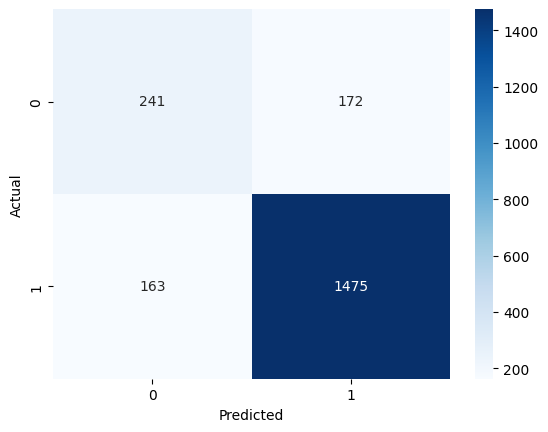

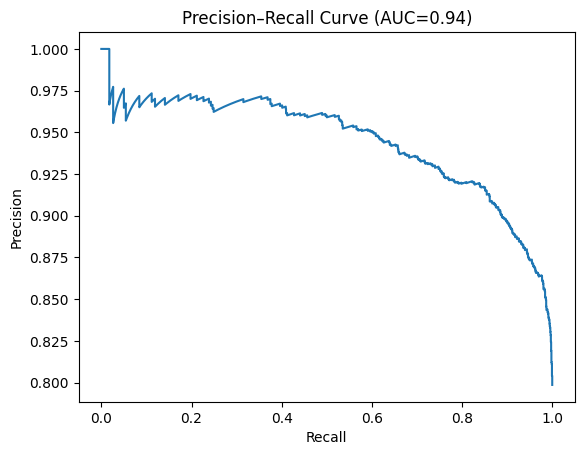

In [ ]:
# =====================================================
# STEP 10: EVALUATION & ROC–AUC
# =====================================================
y_prob = ensemble_model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("ROC–AUC:", roc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Precision–Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve (AUC={pr_auc:.2f})')
plt.show()

In [ ]:
# =====================================================
# STEP 11: SAVE TRAINED MODELS
# =====================================================

# Save models
cnn_model.save("cnn_c2_detector.h5")
lstm_model.save("lstm_c2_detector.h5")
ensemble_model.save("ensemble_c2_detector.h5")

print("✅ Models saved successfully")


✅ Models saved successfully


In [ ]:
# =====================================================
# STEP 12.1: LOAD MODEL
# =====================================================

from tensorflow.keras.models import load_model

model = load_model("ensemble_c2_detector.h5")
print("✅ Ensemble model loaded")


✅ Ensemble model loaded


In [ ]:
# =====================================================
# STEP 12.2: TEST PREDICTIONS ON TEST SET
# =====================================================

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Normal", "Botnet C2"]))


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step
              precision    recall  f1-score   support

      Normal       0.60      0.58      0.59       413
   Botnet C2       0.90      0.90      0.90      1638

    accuracy                           0.84      2051
   macro avg       0.75      0.74      0.74      2051
weighted avg       0.84      0.84      0.84      2051



In [ ]:
# =====================================================
# STEP 12.3: SINGLE FLOW PREDICTION (SOC ALERT)
# =====================================================

def predict_flow(flow_sequence, threshold=0.5):
    """
    flow_sequence: shape (1, SEQUENCE_LEN, FEATURES)
    """
    prob = model.predict(flow_sequence)[0][0]
    label = "BOTNET C2 🚨" if prob > threshold else "NORMAL ✅"
    return label, prob

# Example: take one sample from test data
sample_flow = X_test[0].reshape(1, SEQUENCE_LEN, FEATURES)

label, probability = predict_flow(sample_flow)

print("Prediction:", label)
print("Confidence:", round(probability, 4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction: BOTNET C2 🚨
Confidence: 0.7405


In [ ]:
# =====================================================
# STEP 12.4: BATCH PREDICTION
# =====================================================

predictions = model.predict(X_test[:20])

for i, p in enumerate(predictions):
    status = "BOTNET C2 🚨" if p > 0.5 else "NORMAL ✅"
    print(f"Flow {i+1}: {status} (prob={p[0]:.3f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Flow 1: BOTNET C2 🚨 (prob=0.740)
Flow 2: BOTNET C2 🚨 (prob=0.739)
Flow 3: BOTNET C2 🚨 (prob=0.889)
Flow 4: BOTNET C2 🚨 (prob=0.558)
Flow 5: NORMAL ✅ (prob=0.029)
Flow 6: NORMAL ✅ (prob=0.128)
Flow 7: BOTNET C2 🚨 (prob=0.987)
Flow 8: NORMAL ✅ (prob=0.110)
Flow 9: BOTNET C2 🚨 (prob=0.609)
Flow 10: BOTNET C2 🚨 (prob=0.934)
Flow 11: BOTNET C2 🚨 (prob=0.978)
Flow 12: BOTNET C2 🚨 (prob=0.993)
Flow 13: BOTNET C2 🚨 (prob=0.862)
Flow 14: BOTNET C2 🚨 (prob=0.842)
Flow 15: BOTNET C2 🚨 (prob=0.845)
Flow 16: BOTNET C2 🚨 (prob=0.987)
Flow 17: BOTNET C2 🚨 (prob=0.922)
Flow 18: BOTNET C2 🚨 (prob=0.936)
Flow 19: BOTNET C2 🚨 (prob=0.555)
Flow 20: BOTNET C2 🚨 (prob=0.975)
